In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rioxarray as rxr
import earthpy as et

# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")

In [2]:
# Define relative path to file
lidar_dem_path = os.path.join("data",
                                "data",
                                "colorado-flood",
                              "spatial",
                              "boulder-leehill-rd",
                              "pre-flood",
                              "lidar",
                              "pre_DTM.tif")

# Open lidar dem
lidar_dem_xr = rxr.open_rasterio(lidar_dem_path, masked=True)
lidar_dem_xr

<xarray.DataArray (band: 1, y: 2000, x: 4000)>
[8000000 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 4.72e+05 4.72e+05 4.72e+05 ... 4.76e+05 4.76e+05
  * y            (y) float64 4.436e+06 4.436e+06 ... 4.434e+06 4.434e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

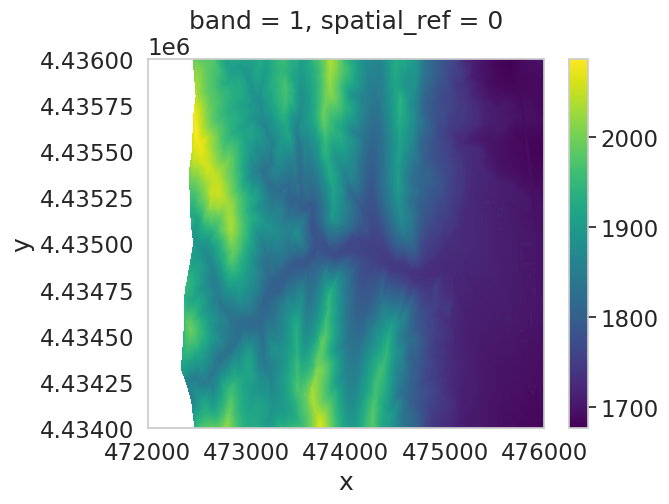

In [3]:
lidar_dem_xr.plot()

In [4]:
# Define relative path to file
lidar_dsm_path = os.path.join("data",
                              "data",
                              "colorado-flood",
                              "spatial",
                              "boulder-leehill-rd",
                              "pre-flood",
                              "lidar",
                              "pre_DSM.tif")

# Open lidar dem
lidar_dsm_xr = rxr.open_rasterio(lidar_dsm_path, masked=True).squeeze()
lidar_dsm_xr

<xarray.DataArray (y: 2000, x: 4000)>
[8000000 values with dtype=float32]
Coordinates:
    band         int64 1
  * x            (x) float64 4.72e+05 4.72e+05 4.72e+05 ... 4.76e+05 4.76e+05
  * y            (y) float64 4.436e+06 4.436e+06 ... 4.434e+06 4.434e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

Canopy Height Model
The canopy height model (CHM) represents the HEIGHT of the trees. This is not an elevation value, rather it’s the height or distance between the ground and the top of the trees (or buildings or whatever object that the lidar system detected and recorded).

Some canopy height models also include buildings, so you need to look closely at your data to make sure it was properly cleaned before assuming it represents all trees!

Calculate difference between two rasters
There are different ways to calculate a CHM. One easy way is to subtract the DEM from the DSM.

DSM - DEM = CHM

This math gives you the residual value or difference between the top of the earth surface and the ground which should be the heights of the trees (and buildings if the data haven’t been “cleaned”).

 Data Tip: Note that this method of subtracting 2 rasters to create a CHM may not give you the most accurate results! There are better ways to create CHM’s using the point clouds themselves. However, in this lesson you learn this method as a means to get more familiar with the CHM dataset and to understand how to perform raster calculations in Python.

Before you subtract the two rasters. Before performing this calculate however you should check to ensure that they cover the same spatial extent and are of the same spatial resolution (pixel size).

In [5]:
# Are the bounds the same?
print("Is the spatial extent the same?",
      lidar_dem_xr.rio.bounds() == lidar_dsm_xr.rio.bounds())

# Is the resolution the same ??
print("Is the resolution the same?",
      lidar_dem_xr.rio.resolution() == lidar_dsm_xr.rio.resolution())

Is the spatial extent the same? True
Is the resolution the same? True


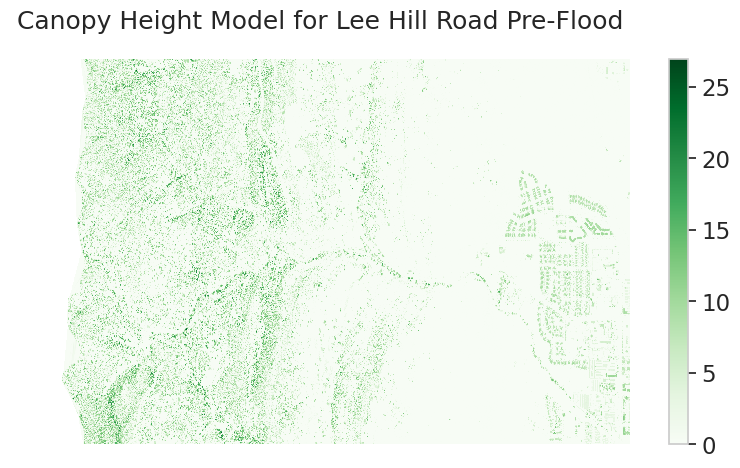

In [6]:
# Calculate canopy height model
lidar_chm_xr = lidar_dsm_xr - lidar_dem_xr

# Plot the data
f, ax = plt.subplots(figsize=(10, 5))
lidar_chm_xr.plot(cmap="Greens")
ax.set(title="Canopy Height Model for Lee Hill Road Pre-Flood")
ax.set_axis_off()
plt.show()

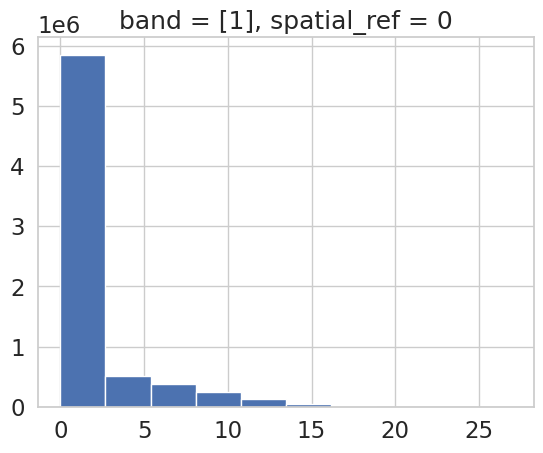

In [7]:
lidar_chm_xr.plot.hist()
plt.show()

In [8]:
print('CHM minimum value: ', np.nanmin(lidar_chm_xr))
print('CHM max value: ', np.nanmax(lidar_chm_xr))

CHM minimum value:  0.0
CHM max value:  26.930054


In [12]:
data_path = os.path.join("data",
                         "data",
                         "colorado-flood",
                         "spatial",
                         "outputs")

if os.path.exists(data_path):
    print("The directory", data_path, "exists!")
else:
    os.makedirs(data_path)

The directory data/data/colorado-flood/spatial/outputs exists!


In [13]:
# Make sure that your output data has a crs & no data value defined
print("The crs is", lidar_chm_xr.rio.crs)
print("The no data value is", lidar_chm_xr.rio.nodata)

The crs is EPSG:32613
The no data value is None


In [14]:
pre_chm_data_path = os.path.join(data_path, "pre-flood-chm.tif")
pre_chm_data_path

'data/data/colorado-flood/spatial/outputs/pre-flood-chm.tif'

In [19]:
lidar_chm_xr = lidar_chm_xr.transpose("band", "y", "x")

In [20]:
# Export data to geotiff
lidar_chm_xr.rio.to_raster(pre_chm_data_path)

In [21]:
# Reopen the data
lidar_chm_data = rxr.open_rasterio(pre_chm_data_path, masked=True).squeeze()
lidar_chm_data

<xarray.DataArray (y: 2000, x: 4000)>
[8000000 values with dtype=float32]
Coordinates:
    band         int64 1
  * x            (x) float64 4.72e+05 4.72e+05 4.72e+05 ... 4.76e+05 4.76e+05
  * y            (y) float64 4.436e+06 4.436e+06 ... 4.434e+06 4.434e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [24]:
lidar_chm_data.rio.crs

CRS.from_epsg(32613)

In [29]:
print(lidar_chm_data.rio.bounds(), lidar_chm_data.rio.resolution())

(472000.0, 4434000.0, 476000.0, 4436000.0) (1.0, -1.0)


In [31]:
import contextily as cx

In [42]:
lidar_chm_data_dropped = lidar_chm_data.where(lidar_chm_data > 12)

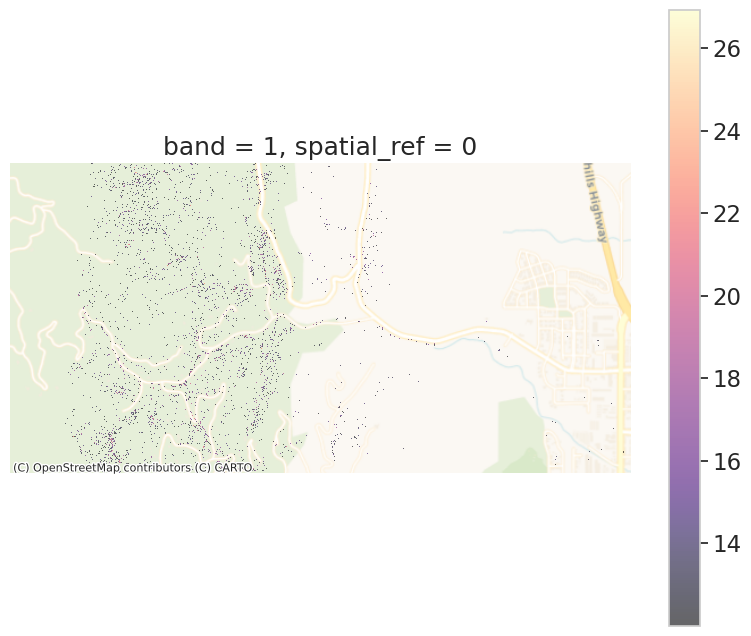

In [45]:
f,ax = plt.subplots(figsize=(10,8))

lidar_chm_data_dropped.plot(cmap="magma", ax=ax, alpha=0.6)
ax.set_axis_off()
ax.set_xlim(lidar_chm_data.rio.bounds()[0], lidar_chm_data.rio.bounds()[2])
ax.set_ylim(lidar_chm_data.rio.bounds()[1], lidar_chm_data.rio.bounds()[3])
cx.add_basemap(ax=ax, crs=lidar_chm_data.rio.crs, source=cx.providers.CartoDB.Voyager)